In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

DATA

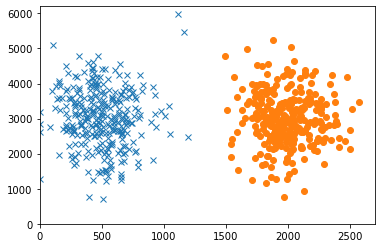

In [2]:
muA = [500, 3000]
muB = [2000, 3000]
SigmaA = [[40000,0], [0,600000]]
SigmaB = [[40000,0], [0,600000]]
n = 300 # sample size
np.random.seed(100)
xA, zA = np.random.multivariate_normal(muA, SigmaA, n).T
# Avoid negatives
xA = list(np.multiply(xA>0,xA))
zA = list(np.multiply(zA>0,zA))
#
xB, zB = np.random.multivariate_normal(muB, SigmaB, n).T
# Avoid negatives
xB = list(np.multiply(xB>0,xB))
zB = list(np.multiply(zB>0,zB))
plt.plot(xA, zA, 'x')
plt.plot(xB, zB, 'o')
balanceMAX = 2700
incomeMAX = 6200
plt.axis([-1, balanceMAX, -1, incomeMAX])
plt.show()

In [3]:
x = xA+xB
z = zA+zB
c = [0]*len(xA) + [1]*len(xB)
import pandas as pd
data1 = {'feature1': x, 'feature2': z, 'class': c}
df = pd.DataFrame(data=data1)
df

,feature1,feature2,class
0,568.536081,1644.637493,0
1,449.512793,3893.137692,0
2,602.843768,3760.127813,0
3,285.991334,3171.325035,0
4,551.000289,2853.217161,0
...,...,...,...
595,1928.299113,2487.301222,1
596,2019.572760,2944.871684,1
597,2143.222183,4371.553737,1
598,2333.635888,2804.774766,1


In [4]:
datas = df.to_numpy()
datas_train, datas_test = train_test_split(datas,test_size=int(len(datas)*0.2),train_size=int(len(datas)*0.8),shuffle=True)

X_train = datas_train[:,:2]
Y_train = datas_train[:,2]

X_test = datas_test[:,:2]
Y_test = datas_test[:,2]

CLASSICAL

In [5]:
model = neighbors.KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))

[[57  0]
 [ 0 63]]
1.0


QUANTUM

In [6]:
def compute_expectation(counts,Y_train):

    cost = 0
        
    for c,y in zip(counts,Y_train):
        if str(int(y)) in c.keys():
            cost += 1 - (c[str(int(y))]/1024)**2
        else:
            cost+=1

    print(cost)
    
    return cost

def create_qaoa_circ(theta,x):

    l = len(theta)//2

    qc = QuantumCircuit(1)
    
    for irep in range(l):
        qc.u(x[0]*theta[irep],x[1]*theta[irep+1],0,0)
            
    qc.measure_all()

    # print(qc.decompose().draw()) 
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        counts = []
        for x in X_train:
            qc = create_qaoa_circ(theta,x)
            counts.append(backend.run(qc, seed_simulator=10, 
                                nshots=shots).result().get_counts())
        return compute_expectation(counts,Y_train)
    
    return execute_circ

In [7]:
from scipy.optimize import minimize

expectation = get_expectation()

res = minimize(expectation, 
                      np.ones(1 * 2), 
                      method='COBYLA')
res

308.73376083374023
316.76592445373535
308.73376083374023
237.0
308.73376083374023
310.42388343811035
237.0
310.42388343811035
300.25544261932373
287.68852615356445
304.59635162353516
237.0
304.59635162353516
306.4898738861084
299.60202980041504
297.5314073562622
237.0
297.5314073562622
348.165584564209
163.36269569396973
348.165584564209
163.36269569396973
348.165584564209
385.02788734436035
77.98571109771729
150.69174766540527
77.98571109771729
150.69174766540527
99.39879417419434
81.88073825836182
77.98571109771729
81.9176607131958


     fun: 81.9176607131958
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([-0.00136484,  1.        ])

In [8]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

Y_pred = []
for x in X_test:
    qc_res = create_qaoa_circ(res.x,x)

    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    z = list(counts.keys())[np.argmax(list(counts.values()))]
    Y_pred.append(int(z))

print(accuracy_score(Y_pred,Y_test))
confusion_matrix(Y_pred,Y_test)

1.0


array([[57,  0],
       [ 0, 63]])

In [83]:
from qiskit.circuit.library import UGate,HGate
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
x = X_train[0]
params = ParameterVector('P', 2)
qc = QuantumCircuit(1)
qc.u(x[0]*params[0],x[1]*params[1],0,0)

qc2 = QuantumCircuit(2,2)
qc2.h(0)
qc_v = qc.bind_parameters([1,0])
g = qc_v.to_gate().control(1)
qc2.append(g,[0,1])
qc2.x(0)
qc_v = qc.bind_parameters([0,1])
g = qc_v.to_gate().control(1)
qc2.append(g,[0,1])
qc2.decompose().draw()

# Statevector.from_instruction(qc2).to_dict()

┌─────────┐                             ┌───────────┐»
q_0: ┤ U2(0,π) ├──────────────■──────────────┤ U3(π,0,π) ├»
     └─────────┘┌─────────────┴─────────────┐└───────────┘»
q_1: ───────────┤ U(1988.36677656949,0,0,0) ├─────────────»
                └───────────────────────────┘             »
c: 2/═════════════════════════════════════════════════════»
                                                          »
«                                  
«q_0: ──────────────■──────────────
«     ┌─────────────┴─────────────┐
«q_1: ┤ U(0,2915.51167189415,0,0) ├
«     └───────────────────────────┘
«c: 2/═════════════════════════════
«